Kanyao Han         
MACS 30100     


# Problem Set 8

In [52]:
import pandas as pd
import numpy as np
from ggplot import *

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import warnings

warnings.filterwarnings("ignore") 
%matplotlib inline

In [5]:
drink = pd.read_csv('strongdrink.txt')

## a) Plot

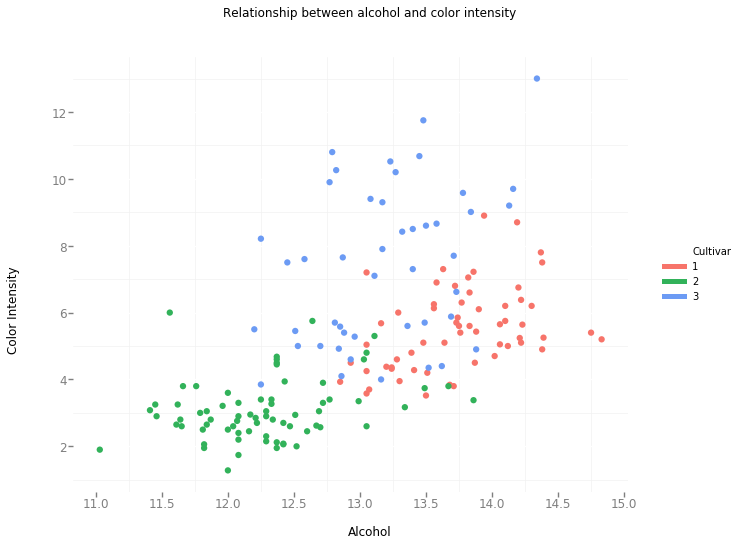

<ggplot: (142477825351)>

In [10]:
drink['Cultivar'] = drink['cultivar'].astype('str')
ggplot(aes(x='alco', y='color_int', color = 'Cultivar'), data=drink) +\
    geom_point(size = 40) +\
    theme_bw() +\
    labs(title = "Relationship between alcohol and color intensity",
         x = "Alcohol",
         y = "Color Intensity") 

In [6]:
Xvars = drink[['alco', 'malic', 'tot_phen', 'color_int']].values
yvals = drink['cultivar'].values

## b) Logistic Regression

In [187]:
k = 4
kf = KFold(n_splits=k, random_state=22, shuffle=True)
kf.get_n_splits(Xvars)
MSE = np.zeros(k)
C = np.zeros(200)
MSE_C = np.zeros(200)

for c in range(200):
    k_ind = int(0)
    for train_index, test_index in kf.split(Xvars):
        X_train, X_test = Xvars[train_index], Xvars[test_index]
        y_train, y_test = yvals[train_index], yvals[test_index]
        LogReg = LogisticRegression(multi_class='multinomial',
                                    solver='newton-cg', C = (c/100 + 0.01))
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        error = y_test != y_pred
        MSE[k_ind] = error.mean()
        k_ind += 1
    C[c] = c/100 + 0.01
    MSE_C[c] =  MSE.mean()
MSE_logit = pd.DataFrame({'C':C, 'MSE':MSE_C})

#### <span style="color:red">Coding Technique</span>
<span style="color:red"> It is worth noting that the multinomial logistic method in sklearn can only use 'l2' penalty (only binary models can use both 'l1' and 'l2'). Therefore, we can only play with the parameter of C, although the problem set asks us to play with both penalty and C. 

In [188]:
MSE_logit.sort_values(['MSE']).head(25)

,C,MSE
43,0.44,0.068182
44,0.45,0.068182
42,0.43,0.068182
41,0.42,0.068182
40,0.41,0.068182
39,0.40,0.068182
27,0.28,0.068182
28,0.29,0.068182
29,0.30,0.068182
30,0.31,0.068182


<span style="color:blue"> According to the table, **when C = 0.44 (penalty is 'l2'), the multinomial logistic model get the lowest MSE of 0.068182**. Generally, when the C is between 0.28 to 0.48, the MSE are similarily low.

## c) Random Forest

In [179]:
MSE_loop = pd.DataFrame({"n_estimator" : np.zeros(5),
                         "min_sample" : np.zeros(5),
                         "max_depth" : np.zeros(5),
                         "MSE" : np.zeros(5)})
MSE_RF = MSE_loop[:0]

for ml in range(15):
    for md in range(15):
        for tree in range(5):
            RF = RandomForestClassifier(n_estimators = (tree * 50 + 50),
                                        min_samples_leaf = (ml * 5 + 5),
                                        max_depth = (md + 1), bootstrap=True, 
                                        oob_score=True, random_state=22)
            RF.fit(Xvars, yvals)
            MSE_loop["n_estimator"][tree] = tree * 50 + 50
            MSE_loop["max_depth"][tree] = md + 1
            MSE_loop["min_sample"][tree] = ml * 5 + 5
            MSE_loop["MSE"][tree] = 1 - RF.oob_score_
        MSE_RF = pd.concat([MSE_RF, MSE_loop])

In [181]:
MSE_RF.index = range(len(MSE_RF))
MSE_RF.sort_values(['MSE']).head(25)

,MSE,max_depth,min_sample,tree
96,0.068182,5.0,10.0,100.0
126,0.068182,11.0,10.0,100.0
116,0.068182,9.0,10.0,100.0
131,0.068182,12.0,10.0,100.0
111,0.068182,8.0,10.0,100.0
106,0.068182,7.0,10.0,100.0
121,0.068182,10.0,10.0,100.0
101,0.068182,6.0,10.0,100.0
136,0.068182,13.0,10.0,100.0
86,0.068182,3.0,10.0,100.0


<span style="color:blue"> **When max_depth = 5, min_sample_leaf = 10 and tree = 100, the random forest model get the lowest MSE of 0.068182.** Besides, there are many parameter settings that can achieve very similar MSE as the table shows, but the min_sample_leaf is always 10 and the n_estimators is usually 100.

## d) Support Vector Machine

In [154]:
k = 4
kf = KFold(n_splits=k, random_state=22, shuffle=True)
kf.get_n_splits(Xvars)
MSE = np.zeros(k)
MSE_C = pd.DataFrame({"C" : np.zeros(80),
                      "G" : np.zeros(80),
                      "MSE" : np.zeros(80)})
MSE_SVM = MSE_C[:0]

for g in range(80):
    for c in range(80):
        k_ind = int(0)
        for train_index, test_index in kf.split(Xvars):
            X_train, X_test = Xvars[train_index], Xvars[test_index]
            y_train, y_test = yvals[train_index], yvals[test_index]
            svc = svm.SVC(kernel='rbf', gamma = (g/20 + 0.05),
                          C=c/20 + 0.05)
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_test)
            error = y_test != y_pred
            MSE[k_ind] = error.mean()
            k_ind += 1
        MSE_C['C'][c] = c/20 + 0.05
        MSE_C['G'][c] = g/20 + 0.05
        MSE_C['MSE'][c] =  MSE.mean()
    MSE_SVM = pd.concat([MSE_SVM, MSE_C])

In [156]:
MSE_SVM.index = range(len(MSE_SVM))
MSE_SVM.sort_values(['MSE']).head(25)

,C,G,MSE
2659,1.00,1.70,0.045455
2578,0.95,1.65,0.045455
2658,0.95,1.70,0.045455
224,3.25,0.15,0.051136
225,3.30,0.15,0.051136
226,3.35,0.15,0.051136
227,3.40,0.15,0.051136
228,3.45,0.15,0.051136
229,3.50,0.15,0.051136
218,2.95,0.15,0.051136


<span style="color:red"> **When cost = 1, gamma = 1.7, the SVM model can get the lowest MSE of 0.045455.** In the same vein as before, there are another two parameter settings that can achieve similar MSE.

## e) MLP Neural Network

In [183]:
k = 4
kf = KFold(n_splits=k, random_state=22, shuffle=True)
kf.get_n_splits(Xvars)
MSE = np.zeros(k)
activ = np.array(['identity', 'logistic', 'tanh', 'relu'])
MSE_al = pd.DataFrame({"activation" : np.zeros(20),
                       "hidden layer" : np.zeros(20),
                       "alpha" : np.zeros(20),
                       "MSE":np.zeros(20)})
MSE_mlp = MSE_al[:0]

for ac in range(4):
    for h in range(8):
        for al in range(20):
            k_ind = int(0)
            for train_index, test_index in kf.split(Xvars):
                X_train, X_test = Xvars[train_index], Xvars[test_index]
                y_train, y_test = yvals[train_index], yvals[test_index]
                mlp = MLPClassifier(activation=activ[ac], solver='lbfgs',
                                    alpha=(al/20 + 0.05), 
                                    hidden_layer_sizes = ((50 * (h + 1)),))
                mlp.fit(X_train, y_train)
                y_pred = mlp.predict(X_test)
                error = y_test != y_pred
                MSE[k_ind] = error.mean()
                k_ind += 1
            MSE_al['activation'][al] = activ[ac]
            MSE_al['hidden layer'][al] = 50 * (h + 1)
            MSE_al['alpha'][al] = al/20 + 0.05
            MSE_al['MSE'][al] =  MSE.mean()
        MSE_mlp = pd.concat([MSE_mlp, MSE_al])  

In [185]:
MSE_mlp.index = range(len(MSE_mlp))
MSE_mlp.sort_values(['MSE']).head(25)

,MSE,activation,alpha,hidden layer
553,0.034091,relu,0.70,200.0
626,0.039773,relu,0.35,400.0
606,0.039773,relu,0.35,350.0
622,0.039773,relu,0.15,400.0
514,0.039773,relu,0.75,100.0
608,0.039773,relu,0.45,350.0
555,0.045455,relu,0.80,200.0
546,0.045455,relu,0.35,200.0
605,0.045455,relu,0.30,350.0
603,0.045455,relu,0.20,350.0


<span style="color:red"> **When activation = relu, alpha = 0.7 and hidden layer = 200, the MLP model can get the lowest MSE of 0.034091.** In addition, there are several other parameter settings that can achieve slightly higher, but still amazing, MSE. It is also worth noting that the top best MSEs are all achieved by the 'relu' activation.

## Comparison

In [219]:
top_logit = np.array(MSE_logit.sort_values(['MSE']).head(5)['MSE'])
top_RF = np.array(MSE_RF.sort_values(['MSE']).head(5)['MSE'])
top_SVM = np.array(MSE_SVM.sort_values(['MSE']).head(5)['MSE'])
top_mlp = np.array(MSE_mlp.sort_values(['MSE']).head(5)['MSE'])
rank = ['1', '2', '3', '4', '5']

Com = pd.DataFrame({'Logit':top_logit, 
                    'RF':top_RF,
                    'SVM':top_SVM,
                    'MLP':top_mlp,
                    'rank':rank})
Com

,Logit,MLP,RF,SVM,rank
0,0.068182,0.034091,0.068182,0.045455,1
1,0.068182,0.039773,0.068182,0.045455,2
2,0.068182,0.039773,0.068182,0.045455,3
3,0.068182,0.039773,0.068182,0.051136,4
4,0.068182,0.039773,0.068182,0.051136,5


Text(0,0.5,'Error Rate/MSE')

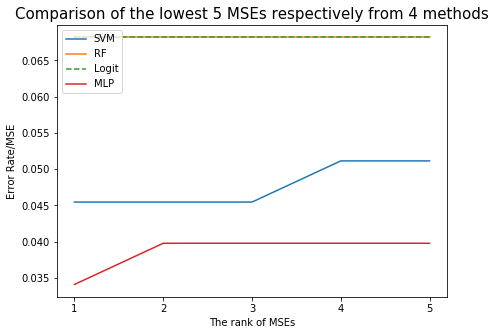

In [228]:
plt.figure(figsize=(7,5))
plt.plot(Com['rank'], Com['SVM'], label='SVM')
plt.plot(Com['rank'], Com['RF'], label='RF')
plt.plot(Com['rank'], Com['Logit'], label='Logit', ls =  'dashed')
plt.plot(Com['rank'], Com['MLP'], label='MLP')
plt.legend(loc='upper left')
plt.title('Comparison of the lowest 5 MSEs respectively from 4 methods', fontsize = 15)
plt.xlabel('The rank of MSEs')
plt.ylabel("Error Rate/MSE")

<span style="color:red"> It is obviously that the MLP neural network model (activation = relu, alpha = 0.7 and hidden layer = 200) is the best predictor of cultivar. If we are afraid that the single lowest MSE might result from coincidence, we can also compare the 5 best models respectively from different methods. As the table shows, the result does not change. In terms of MSE, the top 5 models from MLP neural network are constantly better than those from SVM method, and those from multinomial logit and random forest are consistently the worst predictive models.